In [1]:
import sys
sys.path.insert(0, "../../src/chung/")

import json

import numpy as np
import matplotlib.pyplot as plt

model_colors = {"lstm": "cyan", "gru": "orange", "tanh": "lime"}
models = model_colors.keys()
valid_colors = {"lstm": "blue", "gru": "red", "tanh": "green"}
dataset_titles = {
    "all": "All Music Datasets Combined",
    "jsb": "JSB Chorales",
    "muse": "MuseData",
    "nott": "Nottingham",
    "piano": "Piano-midi",
    "en_de": "IWSLT2017 English to German",
    "de_it": "IWSLT2017 German to Italian",
    "it_en": "IWSLT2017 Italian to English"}
music_datasets = ["all", "jsb", "muse", "nott", "piano"]
translation_datasets = ["en_de", "de_it", "it_en"]

This notebook codes up the training objective plots for each dataset. We explored 3 different RNNs (LSTM, GRU, Tanh) for each dataset. The model was either trained with Binary Cross Entropy objective (for music sequence modeling) or with Cross Entropy objective (for machine translation). We also used negative log-likelihood (NLL) of the ground truth sequence as a metric of measuring how well the model is doing per epoch.

Note that each model was given very similar amount of parameters for comparable results. Music sequence models had about 200K each and translation models had about 20M each. The training setting between them are all the same, with the hidden state dimension of the RNN being the only difference.

First, let's get the training information of all runs:

In [2]:
states = {}

for dataset in music_datasets:
    for model in models:
        with open(f"../../src/chung/exp/music/{dataset}/{model}/latest/states.json", "r") as f:
            states[f"{dataset}_{model}"] = json.load(f)

for dataset in translation_datasets:
    for model in models:
        with open(f"../../src/chung/exp/translation/{dataset}/{model}/latest/states.json", "r") as f:
            states[f"{dataset}_{model}"] = json.load(f)

Each run has some of the following information:

In [3]:
states['en_de_lstm'].keys()

dict_keys(['epoch', 'train_loss', 'valid_loss', 'train_metric', 'valid_metric', 'bleu_score'])

We're mainly concerned with the loss and metrics. Here're the code for plotting objectives and metrics:

In [4]:
def plot_loss(dataset_name, states, figsize, subset=None, save=False):
    epochs = len(states[f"{dataset_name}_{list(models)[0]}"]["train_loss"])
    if subset is None:
        subset = epochs
    if subset > epochs:
        subset = epochs
    fig, ax = plt.subplots(figsize=figsize)
    xticks = np.arange(0, subset+1, subset // 10).tolist()

    for model in models:
        ax.plot(range(subset), states[f"{dataset_name}_{model}"]["train_loss"][:subset],
                linestyle='-', color=model_colors[model], label=f"{model}_train")
    for model in models:
        ax.plot(range(subset), states[f"{dataset_name}_{model}"]["valid_loss"][:subset],
                linestyle='-', color=valid_colors[model], label=f"{model}_valid")
    ax.legend(loc="upper right")
    ax.set_xticks(xticks)
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Loss")
    ax.set_title(f"Loss on {dataset_titles[dataset_name]}")
    
    if save:
        fig.savefig(f"../../src/chung/img/{dataset_name}_loss.jpg", format="jpeg")
    plt.show()
    
def plot_metric(dataset_name, states, figsize, subset=None, save=False):
    epochs = len(states[f"{dataset_name}_{list(models)[0]}"]["train_metric"])
    if subset is None:
        subset = epochs
    if subset > epochs:
        subset = epochs
    fig, ax = plt.subplots(figsize=figsize)
    xticks = np.arange(0, subset+1, subset // 10).tolist()

    for model in models:
        ax.plot(range(subset), states[f"{dataset_name}_{model}"]["train_metric"][:subset],
                linestyle='-', color=model_colors[model], label=f"{model}_train")
    for model in models:
        ax.plot(range(subset), states[f"{dataset_name}_{model}"]["valid_metric"][:subset],
                linestyle='-', color=valid_colors[model], label=f"{model}_valid")
    ax.legend(loc="upper right")
    ax.set_xticks(xticks)
    ax.set_xlabel("Epochs")
    ax.set_ylabel("NLL")
    ax.set_title(f"Negative log-likelihood of Ground Truth on {dataset_titles[dataset_name]}")
    
    if save:
        fig.savefig(f"../../src/chung/img/{dataset_name}_nll.jpg", format="jpeg")
    plt.show()

## Music Datasets

#### Loss

First, let's look at how the objective changed throughout 500 epochs for each dataset.

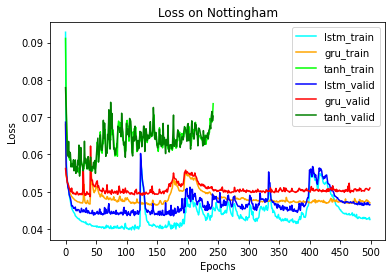

In [5]:
plot_loss("nott", states, (6, 4), save=True)

The `tanh_train` and `tanh_valid` losses are cut off here because the model found infinite gradients (even under gradient clipping and norm) and outputted NaN for losses. Several other models did this very deep in the latter epochs as well.

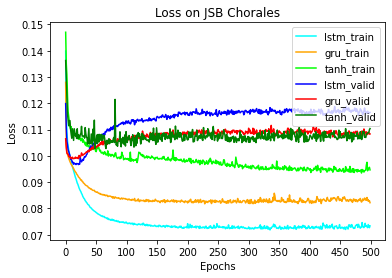

In [6]:
plot_loss("jsb", states, (6, 4), save=True)

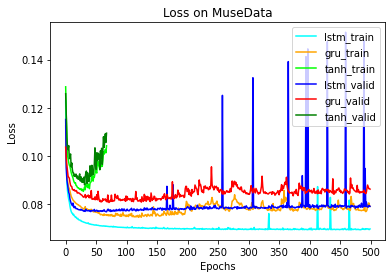

In [7]:
plot_loss("muse", states, (6, 4), save=True)

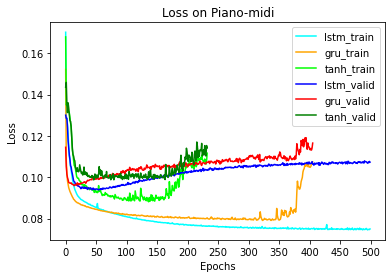

In [8]:
plot_loss("piano", states, (6, 4), save=True)

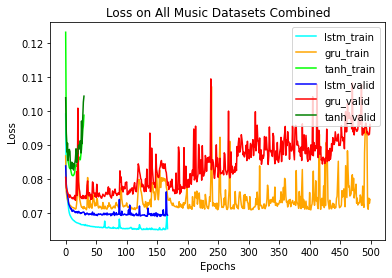

In [9]:
plot_loss("all", states, (6, 4), save=True)

Some observations:
* GRUs and LSTMs generally performed better than Tanh Elman RNNs.
* Whether GRU or LSTM is better depends on the dataset. On certain datasets LSTMs overfit heavily (JSB Chorales). However, LSTMs had lower validation loss than GRUs on most datasets.
* None of the models can escape the problem of exploding gradients even with gradient clipping.

#### Negative log-likelihood

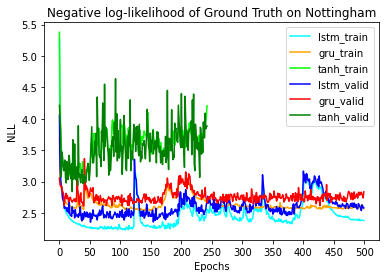

In [10]:
plot_metric("nott", states, (6, 4), save=True)

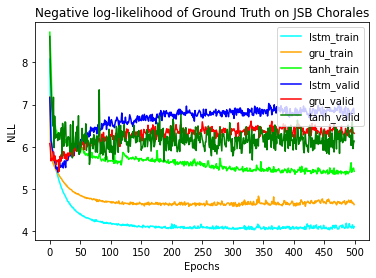

In [11]:
plot_metric("jsb", states, (6, 4), save=True)

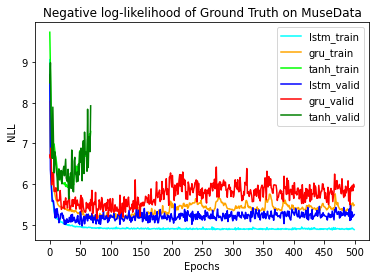

In [12]:
plot_metric("muse", states, (6, 4), save=True)

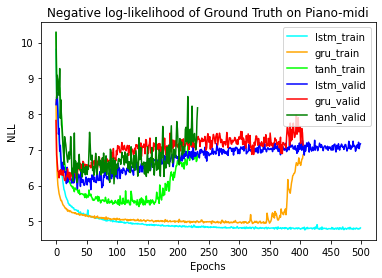

In [13]:
plot_metric("piano", states, (6, 4), save=True)

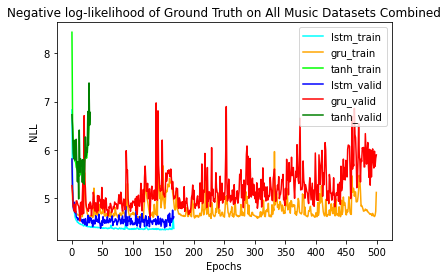

In [14]:
plot_metric("all", states, (6, 4), save=True)

The negative log-likelihood looks exactly like the loss because the two are almost the same thing. Binary cross entropy loss accounts for where the model is incorrect but negative log-likelihood only look at the correct parts in the sequences.

## Translation Datasets

Generally, we found overfitting in the music datasets in the latter epochs. The same is reflected very quickly in the earlier epochs for the translation datasets. Note that translation models used 2 layers of RNN whereas music sequence model only used 1. Ablation experiments show that 2 layers out of (1, 2, 3, 4) layers is the best for performance.

#### Loss

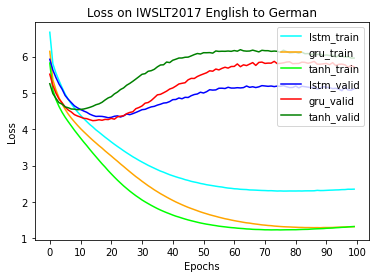

In [15]:
plot_loss("en_de", states, (6, 4), save=True)

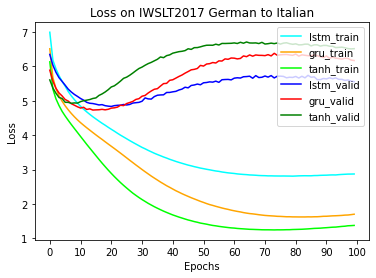

In [16]:
plot_loss("de_it", states, (6, 4), save=True)

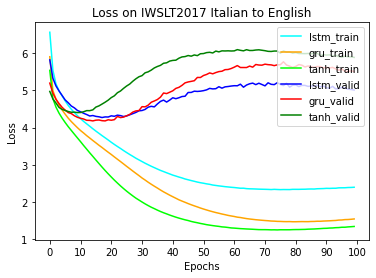

In [17]:
plot_loss("it_en", states, (6, 4), save=True)

Some observations:
* Tanh Elman RNNs generally overfitted much faster than the other models. Tanh Elman RNNs also had a much deeper training loss than the other models.
* LSTMs overfitted the least usually, but GRUs had the least validation loss at some point.
* Models generally converged around 20 epochs.

#### Negative log-likelihood

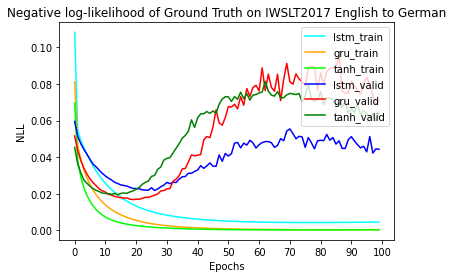

In [18]:
plot_metric("en_de", states, (6, 4), save=True)

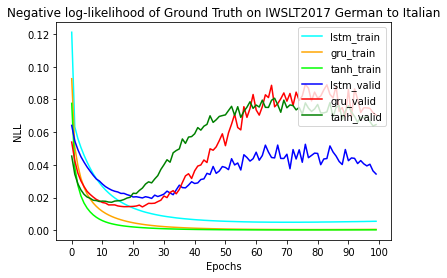

In [19]:
plot_metric("de_it", states, (6, 4), save=True)

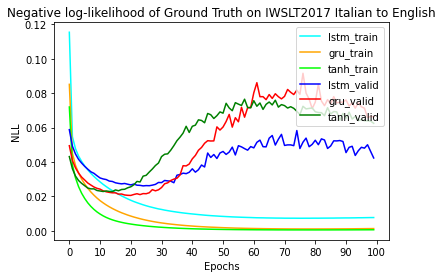

In [20]:
plot_metric("it_en", states, (6, 4), save=True)